In [2]:
import openpyxl
import pandas as pd
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from nbclient.client import timestamp
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Чтение данных из Excel
ticker = 'SBER'
file_path = ticker+'.xlsx'
df = pd.read_excel(file_path, skiprows=0
                   #, names=['DATE', "CLOSE"])
                   , names=['TICKER', 'PER', 'DATE', 'TIME', 'CLOSE'])

# Преобразование даты в правильный формат
df['DATE'] = pd.to_datetime(df['DATE'], format='%d.%m.%y')
# Создаем timestamp из даты (время в данных не используется)
df['timestamp'] = df['DATE']

# Создание DataFrame с необходимыми колонками
data = df[
    ['timestamp','CLOSE']
].rename(columns={'CLOSE': 'target'})
data = data.set_index('timestamp')

In [3]:
# Создаем регулярный временной ряд
full_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
data = data.reindex(full_dates)

# Реиндексация DataFrame на полный диапазон дат и заполнение пропусков
data = data.ffill()

# Подготовка данных в формате AutoGluon
ts_data = data.reset_index()
ts_data.columns = ['timestamp', 'target']
ts_data['item_id'] = ticker  # Для единичного временного ряда

In [4]:
data

,target
2020-01-01,255.00
2020-01-02,255.00
2020-01-03,255.00
2020-01-04,255.00
2020-01-05,255.00
...,...
2025-01-28,275.23
2025-01-29,278.35
2025-01-30,280.36
2025-01-31,281.97


In [5]:
from datetime import datetime, timedelta

def get_date_n_days_ago(date_str, n):
    # Преобразуем строку в объект datetime
    date_format = "%Y-%m-%d"
    date_obj = datetime.strptime(date_str, date_format)

    # Вычитаем N дней
    new_date_obj = date_obj - timedelta(days=n)

    # Преобразуем результат обратно в строку
    new_date_str = new_date_obj.strftime(date_format)

    return new_date_str

In [6]:
# Явное указание частоты
freq = 'D'
N = 15 #Прогноз на N дней
# Разделение на train/test (последние 30 дней - тест)
split_date = '2025-01-01'
shown_date = get_date_n_days_ago(split_date, N)
shown_data = TimeSeriesDataFrame(ts_data[ts_data['timestamp'] >= shown_date])[:2*N]
train_data = TimeSeriesDataFrame(ts_data[ts_data['timestamp'] < split_date])
test_data = TimeSeriesDataFrame(ts_data[ts_data['timestamp'] >= split_date])[:N]

In [7]:
# Инициализация предиктора
predictor = TimeSeriesPredictor(
    target='target',
    prediction_length=N,
    path="autogluon_sber_chronos",
    freq='D'
)

models = ["bolt_base", "bolt_small", "bolt_mini", "bolt_tiny"]

# Обучение с использованием только Chronos
predictor.fit(
    train_data,
    hyperparameters={
            "Chronos": [
                {
                    "model_path": m,
                    "context_length": ln,
                    "num_samples": ln // 3,
                    #"fine_tune": True if m == "bolt_small" and ln == 150 else False,
                    "ag_args": {"name_suffix": "Chronos_"+str(m)+"_"+str(ln)}
                } for ln in (720, 548, 365, 200, 150, 100) for m in models
                # {
                #     "model_path": "bolt_base",
                #     "fine_tune": True,
                #     "ag_args": {"name_suffix": "FineTuned"},
                #     "context_length": 365,  # Количество дней в контексте
                #     "num_samples": 200     # Количество сэмплов для прогноза
                # },
            ],
        },
    #time_limit=120
)
# Прогнозирование
predictions = predictor.predict(train_data)

Beginning AutoGluon training...
AutoGluon will save models to 'C:\Smak\Programming\PyCharm\Forecasting\autogluon_sber_chronos'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.13.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22000
CPU Count:          16
Pytorch Version:    2.9.1+cu130
CUDA Version:       13.0
GPU Memory:         GPU 0: 8.00/8.00 GB
Total GPU Memory:   Free: 8.00 GB, Allocated: 0.00 GB, Total: 8.00 GB
GPU Count:          1
Memory Avail:       2.89 GB / 15.88 GB (18.2%)
Disk Space Avail:   160.10 GB / 952.62 GB (16.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'Chronos_bolt_base_720'},
                                  'context_length': 720,
                                  'model_path': 'bolt_base',
                                  'num_samples': 240},
                            

	-0.1052       = Validation score (-WQL)
	15.44   s     = Training runtime
	3.11    s     = Validation (prediction) runtime
Training timeseries model ChronosChronos_bolt_small_720[bolt_small]. 
	-0.1111       = Validation score (-WQL)
	0.01    s     = Training runtime
	1.25    s     = Validation (prediction) runtime
Training timeseries model ChronosChronos_bolt_mini_720[bolt_mini]. 
	-0.1090       = Validation score (-WQL)
	0.01    s     = Training runtime
	1.07    s     = Validation (prediction) runtime
Training timeseries model ChronosChronos_bolt_tiny_720[bolt_tiny]. 
	-0.1056       = Validation score (-WQL)
	0.01    s     = Training runtime
	0.99    s     = Validation (prediction) runtime
Training timeseries model ChronosChronos_bolt_base_548[bolt_base]. 
	-0.1117       = Validation score (-WQL)
	0.01    s     = Training runtime
	1.54    s     = Validation (prediction) runtime
Training timeseries model ChronosChronos_bolt_small_548[bolt_small]. 
	-0.1033       = Validation score (-

In [8]:
# Получение предсказаний в правильном формате
forecast = predictions
predicted_values = forecast['mean']
# Фактические значения для сравнения
actual_values = test_data['target'].values[:len(predicted_values)]
shown_values = shown_data['target'].values
# Извлекаем временные метки из индекса
test_timestamps = test_data.index.get_level_values('timestamp')[:len(predicted_values)]
shown_timestamps = shown_data.index.get_level_values('timestamp')

In [9]:
forecast

mean         0.1         0.2         0.3  \
item_id timestamp                                                    
SBER    2025-01-01  279.155457  273.577087  275.902557  277.234833   
        2025-01-02  279.155121  271.362640  274.423309  276.333618   
        2025-01-03  279.704285  270.116913  273.905640  276.230316   
        2025-01-04  280.248260  269.208191  273.493317  276.168945   
        2025-01-05  280.294983  267.621887  272.511475  275.586182   
        2025-01-06  279.920227  265.904572  271.245117  274.658936   
        2025-01-07  279.758820  264.608734  270.415588  274.004822   
        2025-01-08  279.671448  263.365570  269.472137  273.380798   
        2025-01-09  279.360779  261.922211  268.416412  272.618896   
        2025-01-10  279.320770  260.724396  267.694672  272.202789   
        2025-01-11  279.543671  260.062256  267.441467  272.114777   
        2025-01-12  279.483521  259.331909  266.975739  271.897949   
        2025-01-13  279.384308  258.275482  266.266907  271.396759   
        2025-01-14  279.728363  257.575287  265.968262  271.413422   
        2025-01-15  279.846405  257.105530  265.768250  271.330719   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
SBER    2025-01-01  278.260956  279.155457  280.011505  280.975769   
        2025-01-02  277.822083  279.155121  280.393738  281.771729   
        2025-01-03  278.077606  279.704285  281.350403  283.103729   
        2025-01-04  278.328888  280.248260  282.238495  284.374268   
        2025-01-05  278.046509  280.294983  282.569153  284.939240   
        2025-01-06  277.383789  279.920227  282.474060  285.241272   
        2025-01-07  277.007324  279.758820  282.545258  285.613831   
        2025-01-08  276.627014  279.671448  282.664551  285.993469   
        2025-01-09  276.113190  279.360779  282.608368  286.200165   
        2025-01-10  275.888153  279.320770  282.800446  286.546234   
        2025-01-11  275.961060  279.543671  283.148773  287.088745   
        2025-01-12  275.826202  279.483521  283.176239  287.216461   
        2025-01-13  275.540985  279.384308  283.252533  287.450867   
        2025-01-14  275.772064  279.728363  283.752563  288.116486   
        2025-01-15  275.766510  279.846405  283.917725  288.458618   

                           0.8         0.9  
item_id timestamp                           
SBER    2025-01-01  282.069427  283.713135  
        2025-01-02  283.414917  286.057953  
        2025-01-03  285.285095  288.646576  
        2025-01-04  286.903473  290.916168  
        2025-01-05  287.761444  292.406830  
        2025-01-06  288.454407  293.488800  
        2025-01-07  289.069458  294.710327  
        2025-01-08  289.916595  295.980957  
        2025-01-09  290.469757  297.047028  
        2025-01-10  291.081573  298.233734  
        2025-01-11  291.860535  299.396027  
        2025-01-12  292.133942  300.176880  
        2025-01-13  292.632507  301.017334  
        2025-01-14  293.498352  302.212219  
        2025-01-15  294.069946  303.287720

In [10]:
# Расчет метрик
mae = mean_absolute_error(actual_values, predicted_values)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mape = np.mean(np.abs((actual_values - predicted_values)/actual_values)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 3.15
RMSE: 4.54
MAPE: 1.15%


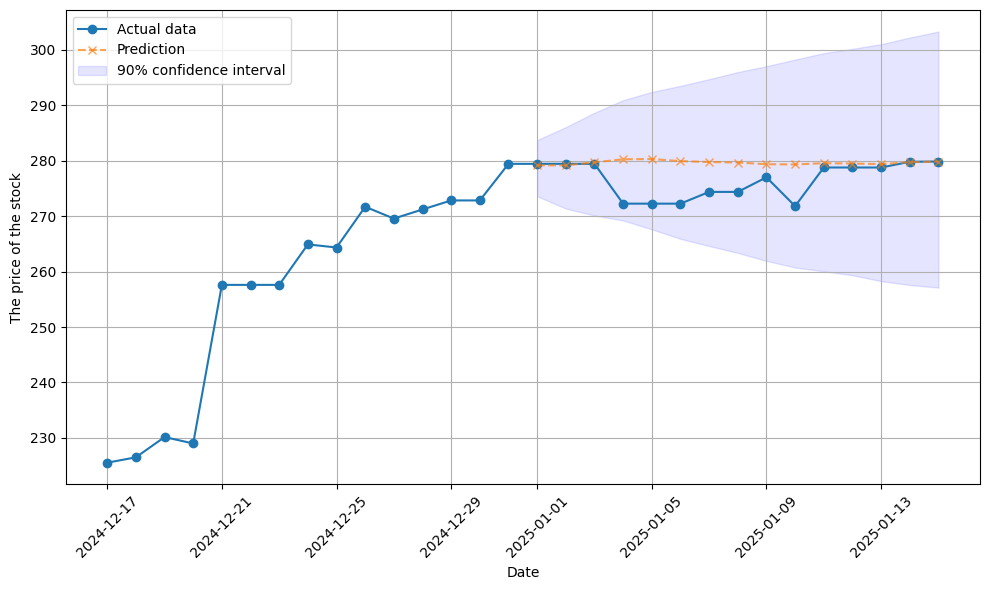

In [11]:
# Визуализация
plt.figure(figsize=(10, 6))

plt.plot(
    shown_timestamps,
    shown_values,
    label='Actual data',
    marker='o',
    linestyle='-'
)

# Строим прогноз (проверяем индекс предсказаний)
forecast_timestamps = predictions.index.get_level_values('timestamp')[:len(predicted_values)]
plt.plot(
    forecast_timestamps,
    predicted_values,
    label='Prediction',
    alpha=0.7,
    linestyle='--',
    marker='x'
)

# Визуализация интервалов
plt.fill_between(
    forecast_timestamps,
    forecast['0.1'],  # 10% квантиль
    forecast['0.9'],  # 90% квантиль
    alpha=0.1,
    color='b',
    label='90% confidence interval'
)

#plt.title('Chronos price forecast for noisy-free series (SBER)')
plt.xlabel('Date')
plt.ylabel('The price of the stock')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Поворот дат для удобства чтения
plt.tight_layout()
plt.show()